$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# TeslaMax Optimization

Teslamax model:

<img src="figures/teslamax.png" width=500>

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)


In [2]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20

TARGET_PROFILE = 1.2

In [3]:
os.chdir('C:\\Users\\fabiofortkamp\\code\\TeslaMax\\')

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
import importlib
importlib.reload(teslamax)

<module 'teslamax' from 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax\\__init__.py'>

## Parameters

This is reference set of parameters that we use to test the optimization procedures:

In [6]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

alpha_B_rem_0 = [15,30,45,15,45,135]


## Principle of superposition and the contribution of each segment

The code below calculate the individual contributions for each magnet block. For instance, the i-th element of the variable `F_II_x` is a list of points in the form $(B_x, B_y)$, calculated in a mesh in the air gap, where only the i-th segment in magnet II has a non-null remanence, with magnitude included in the above dictionary and oriented in the $x$ direction.

This code generates a "mesh" in the upper half-circle (corresponding to the model that is actually simulated by COMSOL), and calculate the $F$-operators in this mesh

In [7]:
%xmode verbose

R_o = params_optimization["R_o"]
R_g = params_optimization["R_o"] + params_optimization["h_gap"]
points_air_gap = teslamax.generate_sector_mesh_points(1.001*R_o,0.999*R_g,0.0,np.pi)

tmpd = TeslaMaxPreDesign(params_optimization)

F_II_x, F_II_y, F_IV_x, F_IV_y = tmpd.calculate_F_operators(points_air_gap)

Exception reporting mode: Verbose


Each of of the $F$-operators is a list of points, corresponding to the vector $\nvb$ that calculated at `points_air_gap`:

In [8]:
F_IV_x[0]

array([[  5.61756084e-01,   1.05129344e-03],
       [  5.60633272e-01,   5.04914805e-03],
       [  5.59536416e-01,   9.25230119e-03],
       ..., 
       [  5.55810806e-01,   3.02591752e-03],
       [  5.55510717e-01,   1.45938969e-03],
       [  5.55230510e-01,  -1.23577793e-04]])

Next we apply the principle of superposition, combining the contributions calculated above and using the actual remanence magnitude and angle as specified by the dictionary `params_optimization` and by the array `alpha_B_rem`.

In [34]:
def superposition_B_III(points, F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params):
    """
    Return (x, y, B_x, B_y) based on the lists of F-operators and a vector of remanence angles.
    
    - 'points' is a list of (x,y) points where all of the F-operators are calculated.
    - Each element of 'F_{magnet}_{direction}' is an array of (B_x, B_y) vectors calculated at 'points', 
    considering only the effect of that segment
    - 'alpha_B_rem' is a vector of (n_II + n_IV) remanences, where the first n_II represent magnet II and
    the remaining elements represent magnet IV
    - 'params' is a dictionary of parameters
    
    """
    
    B_III = 0

    n_II = params["n_II"]
    for k in range(0,n_II):
        B_rem = params["B_rem_II_%d" %(k+1)]
        alpha = np.deg2rad(alpha_B_rem[k])
    
        B = B_rem * (np.cos(alpha) * F_II_x[k] + np.sin(alpha) * F_II_y[k])
    
        B_III = B_III + B
    
    n_IV = params["n_IV"]
    for j in range(0,n_IV):
        B_rem = params["B_rem_IV_%d" %(j+1)]
        alpha = np.deg2rad(alpha_B_rem[n_II + j])
        
        B = B_rem * (np.cos(alpha) * F_IV_x[j] + np.sin(alpha) * F_IV_y[j])
        
        B_III = B_III + B
        
    B_III_grid = np.concatenate((points, B_III), axis=1)
    
    return B_III_grid

## Calculating the functional

The basic computational implementation of optimization algorithms require evaluate an *objective functional*. In this formulation, the main optimization variables are the angles, which are always represented by the vector `alpha_B_rem`. Notice that, in order to efficiently calculate the functional, we have to pass the lists of $F$-operators that we calculated previously, the points where these operators are calculated, and the dictionary of parameters.

Our goal is to build an instantaneous profile. This function calculates it:

In [35]:
def calculate_instantaneous_profile(phi, B_high):
    """
    Calculate the value of the two-pole instantaneous magnetic profile at angular position 'phi' (in degrees),
    where the profile oscillates from 0 to 'B_high'
    
    """
    
    high_region = (phi <= 45)
    high_region = np.logical_or(high_region, np.logical_and((phi >= 135),(phi <= 225)))
    high_region = np.logical_or(high_region, (phi >= 315))
                 
    return np.where(high_region,B_high,0.0)

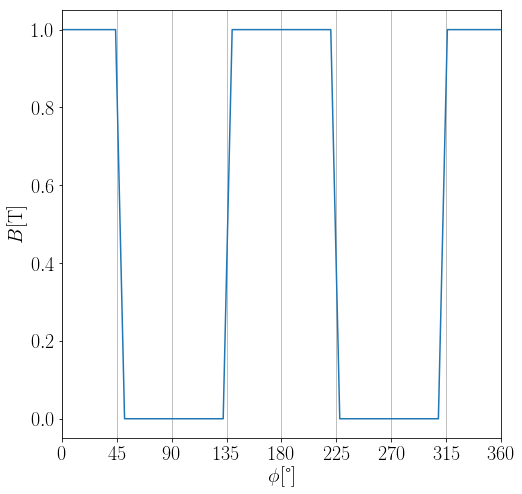

In [36]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

phi_inst_vector = np.linspace(0,360)
B_inst_vector = calculate_instantaneous_profile(phi_inst_vector,1.0)


profile_axes.plot(phi_inst_vector,B_inst_vector)
profile_axes.set_xlim(0,np.max(phi_inst_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_inst_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')




In [37]:
def calculate_functional_average(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params):
    """
    Return the objective functional based on the lists of F-operators and a vector of remanence angles.
    The objective functional is defined as the average high field.
    
    - 'points' is a list of (x,y) points where all of the F-operators are calculated.
    - Each element of 'F_{magnet}_{direction}' is an array of (B_x, B_y) vectors calculated at 'points', 
    considering only the effect of that segment
    - 'alpha_B_rem' is a vector of (n_II + n_IV) remanences, where the first n_II represent magnet II and
    the remaining elements represent magnet IV
    - 'params' is a dictionary of parameters
    
    """
    
    B_III_data = superposition_B_III(points, F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params)
    
    # the above statement will return [x,y,B_x,B_y]. We have to calculate the magnitude to pass it
    # to the magnetic profile data
    B_III_data = teslamax.calculate_magnitude(B_III_data)
    
    B_profile_data = teslamax.calculate_magnetic_profile(B_III_data,params)
    
    S = teslamax.calculate_average_high_field(B_profile_data)
    return S

In [38]:
def calculate_functional_instantaneous(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params):
    """
    Return the objective functional based on the lists of F-operators and a vector of remanence angles.
    The objective functional is defined as the difference between the profile and an instantaneous profile
    of TARGET_PROFILE as the high level.
    
    - 'points' is a list of (x,y) points where all of the F-operators are calculated.
    - Each element of 'F_{magnet}_{direction}' is an array of (B_x, B_y) vectors calculated at 'points', 
    considering only the effect of that segment
    - 'alpha_B_rem' is a vector of (n_II + n_IV) remanences, where the first n_II represent magnet II and
    the remaining elements represent magnet IV
    - 'params' is a dictionary of parameters
    
    """
    
    B_III_data = superposition_B_III(points, F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params)
    
    # the above statement will return [x,y,B_x,B_y]. We have to calculate the magnitude to pass it
    # to the magnetic profile data
    B_III_data = teslamax.calculate_magnitude(B_III_data)
    
    phi_vector, B_profile = teslamax.calculate_magnetic_profile(B_III_data,params).T
    
    B_inst_profile = calculate_instantaneous_profile(phi_vector,TARGET_PROFILE)
    
    # use a "least squares" approach
    B_lsq = (B_inst_profile - B_profile)**2
    S = 1.0/np.trapz(B_lsq,phi_vector)
    
    return S

In [39]:
def calculate_functional(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params):
    return calculate_functional_instantaneous(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params)

An example of calculation:

In [40]:
S_0 = calculate_functional(points_air_gap,F_II_x,F_II_y,F_IV_x, F_IV_y, alpha_B_rem_0,params_optimization)
print(S_0)

0.0478031200303


Another piece of optimization algorithm is a function to calculate the derivative of the funcional:

In [41]:
def calculate_functional_derivative(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, i,params):
    """
    Return the derivative of the functional in respect to the i-th element of the remanence angles vector.
    
    - 'points' is a list of (x,y) points where all of the F-operators are calculated.
    - Each element of 'F_{magnet}_{direction}' is an array of (B_x, B_y) vectors calculated at 'points', 
    considering only the effect of that segment
    - 'alpha_B_rem' is a vector of (n_II + n_IV) remanences, where the first n_II represent magnet II and
    the remaining elements represent magnet IV
    - 'i' is the element (0-based) in respect to which the derivative is being evaluated
    - 'params' is a dictionary of parameters
    
    """
    
    S = calculate_functional(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem, params)
    
    alpha_B_rem_plus = alpha_B_rem.copy()
    delta = 1e-6
    alpha_B_rem_plus[i]  = alpha_B_rem_plus[i] + delta
    
    S_plus = calculate_functional(points,F_II_x, F_II_y, F_IV_x, F_IV_y, alpha_B_rem_plus, params)
    
    dS = (S_plus - S)/delta
    
    return dS

In [42]:
dS_0 = calculate_functional_derivative(points_air_gap,F_II_x,F_II_y,F_IV_x, F_IV_y, alpha_B_rem_0, 2, params_optimization)
print(dS_0)

-0.000157009523438


## Optimization algorithm

This is a prototype of an implementation of the gradient descent algorithm from Insinga (2016):

In [43]:
alpha_B_rem_0 = [15,30,45,15,45,135]
S_0 = calculate_functional(points_air_gap,F_II_x,F_II_y,F_IV_x, F_IV_y, alpha_B_rem_0,params_optimization)

gamma = 1e5
max_iter = 50
tol = 1e-6

i = 0
alpha_B_rem = alpha_B_rem_0.copy()
S_old = S_0

for i in range(0,len(alpha_B_rem)):
    
    it_count = 0
    
    
    while True:
        
        dSdalpha = calculate_functional_derivative(points_air_gap,F_II_x,F_II_y,F_IV_x, F_IV_y, alpha_B_rem, i, params_optimization)
        
        dalpha = gamma * dSdalpha
        alpha_B_rem[i] = alpha_B_rem[i] + dalpha
        
        S = calculate_functional(points_air_gap,F_II_x,F_II_y,F_IV_x, F_IV_y, alpha_B_rem,params_optimization)
        
        dS_rel = abs((S - S_old)/S)
        S_old = S
        
        
        it_count = it_count + 1
        
        max_iter_reached = it_count >= max_iter
        converged = dS_rel < tol
        
        if converged or max_iter_reached:
            break
            
    print("alpha[%d] = %.2f, S = %.7f" %(i, alpha_B_rem[i],S))


alpha[0] = 20.09, S = 0.0478418
alpha[1] = 70.77, S = 0.0502279
alpha[2] = 5.51, S = 0.0553488
alpha[3] = 45.44, S = 0.0420585
alpha[4] = 42.48, S = 0.0425704
alpha[5] = 110.11, S = 0.0591087


To compare, we plot the magnetic profiles before and after the optimization:

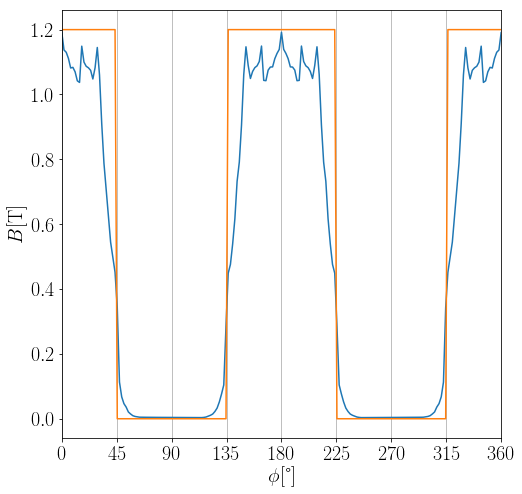

In [44]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

params_reference = teslamax.expand_parameters_from_remanence_array(alpha_B_rem_0, params_optimization)
teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_reference = TeslaMaxModel(params=params_reference,
                   path=teslamax_playground)
tmm_reference.run()
phi_vector, B_vector = tmm_reference.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = calculate_instantaneous_profile(phi_vector,TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [45]:
teslamax.calculate_average_high_field(tmm_reference.get_profile_data())

0.94665096888888867

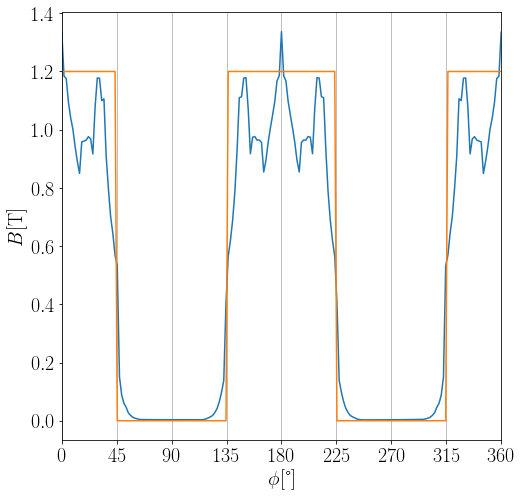

In [46]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)

params_optimized = teslamax.expand_parameters_from_remanence_array(alpha_B_rem, params_optimization)
teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(params=params_optimized,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = calculate_instantaneous_profile(phi_vector,TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [47]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

0.95337943888888865